In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, iradon, rescale

 Auth: Mawaba P. DAO

 03/17/2021

 Florida Institute of Technology
 
 Digital Image Processing: ECE5256 (Dr. Kozaitis)


Proj 5 write up:

            In this project, we first obtain an image and perform a Radon transofrm on the image. Then to get the original image back
            combinations of various filters and interpolations are used in the iverse Radon. The filter, interpolation pair that yields the least
            MSE between the original image and the reconstructed image are used to compute and display the reconstructed image.
            In part 2, the image of a grid is generated. Gaussian noise is added to the the image before computing its Radon transoform. In order to 
            attenuate noise and mostly get back the grid during reconstruction, a ramp filter is used. This lets through higher pixel values, thus mostly
            showing the white grid.

In [18]:
def findRadon(img, theta):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
    # nAngles = max(img.shape)
    ax1.set_title("Input")
    # ax1.imshow(img, cmap=plt.cm.Greys_r)
    ax1.imshow(img, cmap="gray")

    # theta = np.linspace(0., 180., nAngles, endpoint=False)
    # theta = np.linspace(0., 180., 360, endpoint=False)
    sinogram = radon(img, theta=theta, circle=True)
    dx, dy = 0.5 * 180.0 / max(img.shape), 0.5 / sinogram.shape[0]
    ax2.set_title("Radon transform\n(Sinogram)")
    ax2.set_xlabel("Projection angle (deg)")
    ax2.set_ylabel("Projection position (pixels)")
    ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
            extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
            aspect='auto')

    fig.tight_layout()
    plt.show()
    return sinogram

def findMinRecon(sinogram, myImage, theta, verbose=1):
    minMSE = 10000
    print('Running...')
    for _ , filt in enumerate(filters):
        if verbose:
            print(filt)
        for _, intrpl in enumerate(interpols):
            reconstruction_fbp = iradon(sinogram, theta=theta, filter=filt, interpolation=intrpl, circle=True)
            error = (reconstruction_fbp - myImage)
            MSE = np.mean(error**2)
            if verbose:
                print(f"\tInterpolation: {intrpl}, Reconstruction MSE = {MSE:.7g}")

            if (MSE < minMSE):
                minMSE = MSE
                minInt = intrpl
                minFilt = filt

    print('Done.')
    return minMSE, minInt, minFilt

# 1

In [19]:
imgPath = "./imgs/yogi-under-tree.jpg"
og_img= cv2.imread(imgPath, 0)
print(og_img.shape)

(168, 300)


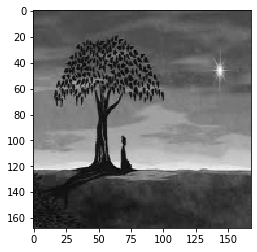

In [20]:
# #Resize
dim = (168, 168)
  
# # resize image
rsz_img = cv2.resize(og_img, dim, interpolation = cv2.INTER_AREA)
# print('Resized Dimensions : ',rsz_img.shape)
plt.imshow(rsz_img, cmap='gray')

## Padding image

Text(0.5, 1.0, 'Padded image')

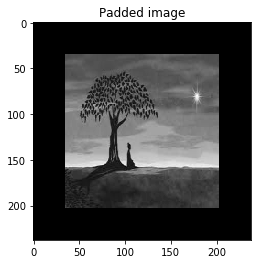

In [21]:
BLACK = [0,0,0]
padding = 35
myImage = cv2.copyMakeBorder(rsz_img,padding,padding,padding,padding,cv2.BORDER_CONSTANT,value=BLACK) #Discuss why you had to do pad the image in order to get an accurate inverse transform
plt.imshow(myImage, cmap='gray')
plt.title('Padded image')

The image is padded because during the radon transform; the length of each 1D projection varies with the angle. 

<img src="./imgs/screenshot.png" width="200" height="200">

As shown in the figure above, the projection of a 256x256 image onto a diagonal only captures the middle 256 points on that line.
The actual length of the diagonal in this case is 362.05, meaning that 106 pixels (53 pixels at each end) are discarded by the transform.
When computing the inverse transfrom this will have the effect of a circular crop on the image. My solution was to padd the image with zeros all around. This will center the actual image of intrest in the figure, and all the discarded pixels the transform will have a value of zero and our inverse transform will be more accurate.

## Finding the Radon transform

/home/pascal/.local/lib/python3.8/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


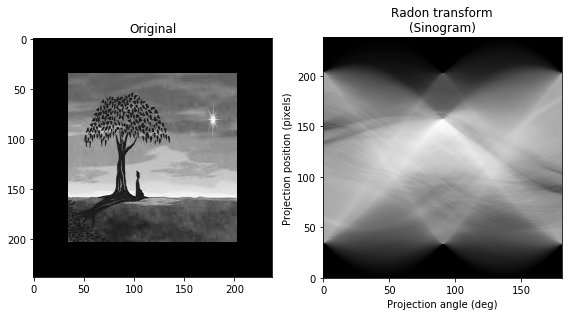

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(myImage, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(myImage.shape), endpoint=False)
# theta = np.linspace(0., 180., 360, endpoint=False)
sinogram = radon(myImage, theta=theta, circle=True)
bad_sinogram = radon(rsz_img, theta=theta, circle=True)

dx, dy = 0.5 * 180.0 / max(myImage.shape), 0.5 / sinogram.shape[0]
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
           aspect='auto')

fig.tight_layout()
plt.show()

## Finding the best inverse Radon Transform

In [23]:
filters = ['ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
interpols = ['linear', 'nearest', 'cubic']
print(f"{len(filters)*len(interpols)} Possible combinations")

15 Possible combinations


In [24]:
minMSE, minInter, minFilter = findMinRecon(sinogram, myImage, theta, verbose=False)

print(f"Min MSE: {minMSE:.7g}")
print(f"Interpolation: {minInter}\nFilter: {minFilter}")

Running...
<ipython-input-18-c4898b3b3968>:30: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  reconstruction_fbp = iradon(sinogram, theta=theta, filter=filt, interpolation=intrpl, circle=True)
Done.
Min MSE: 5746.945
Interpolation: cubic
Filter: ramp


## Image reconstruction

<ipython-input-25-bdcb9f988cc5>:1: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  reconstruction_fbp = iradon(sinogram, theta=theta, filter=minFilter, interpolation=minInter, circle=True)
<ipython-input-25-bdcb9f988cc5>:2: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  bad_reconstruction_fbp = iradon(bad_sinogram, theta=theta, filter=minFilter, interpolation=minInter, circle=True)


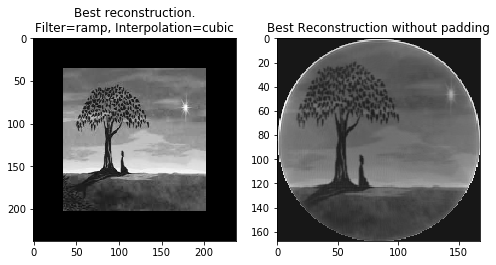

In [25]:
reconstruction_fbp = iradon(sinogram, theta=theta, filter=minFilter, interpolation=minInter, circle=True)
bad_reconstruction_fbp = iradon(bad_sinogram, theta=theta, filter=minFilter, interpolation=minInter, circle=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title(f"Best reconstruction.\nFilter={minFilter}, Interpolation={minInter}")
ax1.imshow(myImage, cmap=plt.cm.Greys_r)
ax2.set_title("Best Reconstruction without padding")
ax2.imshow(bad_reconstruction_fbp, cmap=plt.cm.Greys_r)


# plt.imshow(reconstruction_fbp, cmap="gray")
# plt.title(f"Best reconstruction.\nFilter={minFilter}, Interpolation={minInt}")

The reconstructions above illustrate the previously discussed issue about the radon transform without padding.

# 2 

## Generating image and noisy image

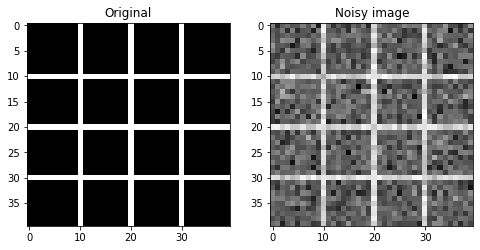

In [26]:
img = np.zeros((40,40), dtype=np.uint8) 
rows = img.shape[0]
cols = img.shape[1]

# color = (255,555,555)
color = (1,1,1)
thickness = 1
lines = np.array([[10,0,10,40],
                  [20,0,20,40],
                  [30,0,30,40],
                  [0,10,40,10],
                  [0,20,40,20],
                  [0,30,40,30]])

for i in range(lines.shape[0]):
    image = cv2.line(img, (lines[i,0], lines[i,1]), (lines[i,2], lines[i,3]), color, thickness) 

fig.tight_layout()
plt.show()

sigma = 0.2*1
mu = 0
noise = sigma * np.random.randn(rows, cols) + mu
noisy_img = img + noise


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))
ax1.set_title("Original")
ax1.imshow(img, cmap=plt.cm.Greys_r)
ax2.set_title("Noisy image")
ax2.imshow(noisy_img, cmap=plt.cm.Greys_r)


## Radon of noisy image

In [27]:
BLACK = [0,0,0]
padding = 5
pad_noisy_img  = cv2.copyMakeBorder(noisy_img,padding,padding,padding,padding,cv2.BORDER_CONSTANT,value=0) # First pad noisy image 

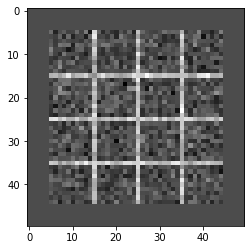

In [28]:
plt.imshow(pad_noisy_img, cmap="gray")

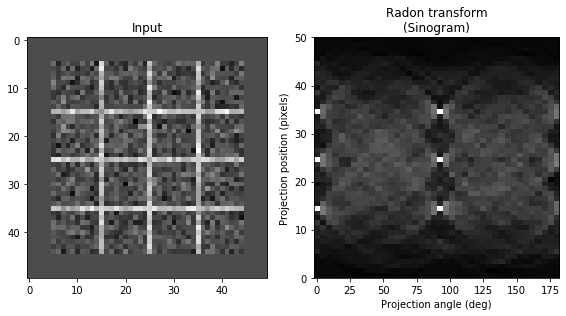

In [29]:

nAngles=max(noisy_img.shape)
theta = np.linspace(0., 180., nAngles, endpoint=False)
sinogram = findRadon(pad_noisy_img, theta)

## Reconstruction

<ipython-input-30-4588454e45c5>:3: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  reconstruction_fbp = iradon(sinogram, theta=theta, filter=filt, interpolation=inter, circle=True)


Text(0.5, 1.0, 'Reconstruction.\nFilter=shepp-logan, Interpolation=nearest')

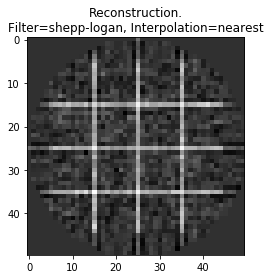

In [30]:
filt = 'shepp-logan'
inter = 'nearest'
reconstruction_fbp = iradon(sinogram, theta=theta, filter=filt, interpolation=inter, circle=True)
plt.imshow(reconstruction_fbp, cmap="gray")
plt.title(f"Reconstruction.\nFilter={filt}, Interpolation={inter}")

The image above shows the reconstruction of our generated noisy image. The filter used was the Shepp-Logan filter because of its characteristics as a high pass filter. Although this reconstruction is is not ideal, using Shepp-Logan is the best choice of a filter because it will let through high value pixels such as those desicribing the grid. In contrast the figure below shows the result of a reconstruction using a cosine filter which is not a high pass filter.

<ipython-input-31-a0a9e4b4ca07>:3: FutureWarning: 'filter' is a deprecated argument name for `iradon`. It will be removed in version 0.19. Please use 'filter_name' instead.
  reconstruction_fbp = iradon(sinogram, theta=theta, filter=filt, interpolation=inter, circle=True)


Text(0.5, 1.0, 'Reconstruction.\nFilter=cosine, Interpolation=nearest')

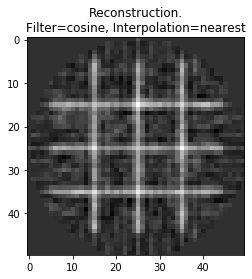

In [31]:
filt = 'cosine'
inter = 'nearest'
reconstruction_fbp = iradon(sinogram, theta=theta, filter=filt, interpolation=inter, circle=True)
plt.imshow(reconstruction_fbp, cmap="gray")
plt.title(f"Reconstruction.\nFilter={filt}, Interpolation={inter}")